# Анализ социального графа в социальной сети [ВКонтакте](https://vk.com)

В данном анализе будут вычислены средняя длина пути и коэффициент кластеризации в кластере друзей [пользователя](https://vk.com/lord_ajdis) ВКонтакте, а также будут приведены некоторые статистические сведения

Для анализа собственного кластера друзей необходимо указать VK API Key в переменной `API_KEY` и **числовой** идентификатор пользователя во ВКонтакте в переменной `ID` в файле `constants.py`

Для получения VK API Key необходимо пройти по [ссылке](https://vkhost.github.io/) выбрать `VK Admin` или `vk.com`, принять OAuth запрос и скопировать ключ из адресной строки (параметр `access_token`)

Для получения числового идентификатора пользователя необходимо перейти по [ссылке](https://regvk.com/id/), вставить в поле ссылку с раздела `Моя страница`, нажать на кнопку "Определить ID" и скопировать содержимое раздела "ID пользователя"

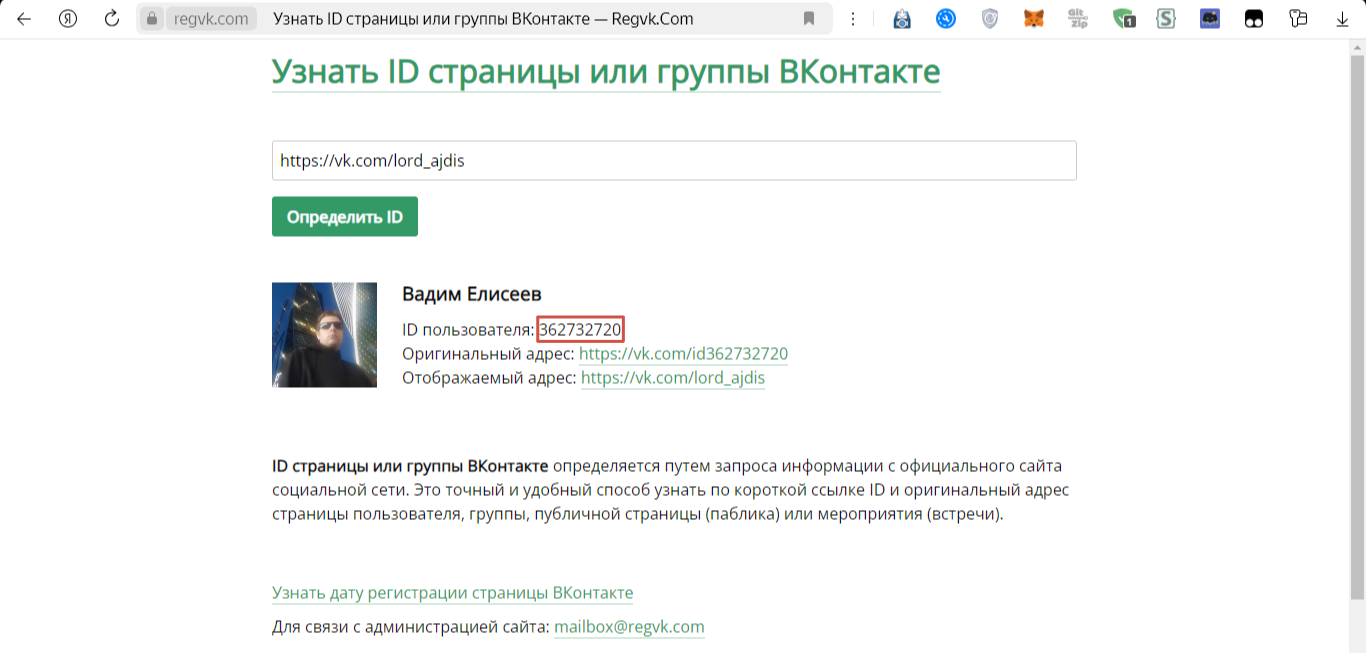

## Импорт необходимых библиотек

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from core.vk_helper import *
from core.tools import convert_to_hours_and_minutes

Установка начальных параметров

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
np.random.seed(316) # для воспроизводимости экспериментов

## Получение и предобработка списка друзей

Авторизация и получение доступа к API ВК

In [5]:
api = auth()
api

Получение списка друзей пользлователя

In [6]:
friends = get_friends_list(api, return_as_dataframe=True)
friends.sample(10)

,id,first_name,last_name
39,179663794,Ярослав,Усенко
29,142437904,Екатерина,Евдачёва
72,446251495,Егор,Швец-Шуст
34,160006436,Иван,Савенков
65,300636519,Артём,Купш
37,170129995,Людмила,Мустафина
7,17525542,Виктор,Кшеминский
73,465302644,Никитос,Денисенко
46,205033239,Олег,Березин
19,87693631,Всеволод,Залевский


Узнаем количество друзей, что будет полезно для дальнейших вычислений

In [7]:
friends_count = friends.shape[0]
friends_count

84

Добавим в датафрейм новый столбец, который будет отображать количество друзей каждого друга

In [8]:
friends['friends_count'] = friends['id'].apply(lambda x: get_friends_count(api, user_id=x))
friends.sample(10)

,id,first_name,last_name,friends_count
71,437550802,Снежана,Снежная,61
51,228617275,Николай,Миронов,57
17,81405266,Михаил,Донецкий,361
83,784972938,Илья,Полянцев,65
0,1288695,Тимофей,Ильин,302
43,186729408,Ирина,Конограева,317
44,201430071,Паша,Солоха,131
66,334860595,Максим,Федоров,114
20,95031711,Денис,Лебедев,188
54,233227361,Анюта,Тертышная,306


Также добавим столбец, показывающий количество общих друзей с каждым из друзей

In [9]:
friends['mutual_count'] = friends['id'].apply(lambda x: get_mutual_count_with(api, user_id=x))
friends.sample(10)

,id,first_name,last_name,friends_count,mutual_count
66,334860595,Максим,Федоров,114,15
42,185040978,Андрей,Чернявский,273,7
32,157093150,Альберт,Воловиков,208,12
47,210860203,Валерий,Перетятько,77,6
41,181651918,Егор,Заярский,232,11
35,165120925,Сергей,Королёв,652,0
62,272476645,Виталий,Бондаренко,297,16
19,87693631,Всеволод,Залевский,86,15
31,155075011,Геннадий,Ломонос,260,15
54,233227361,Анюта,Тертышная,306,3


Построим гистограмму распределения количеств друзей друзей

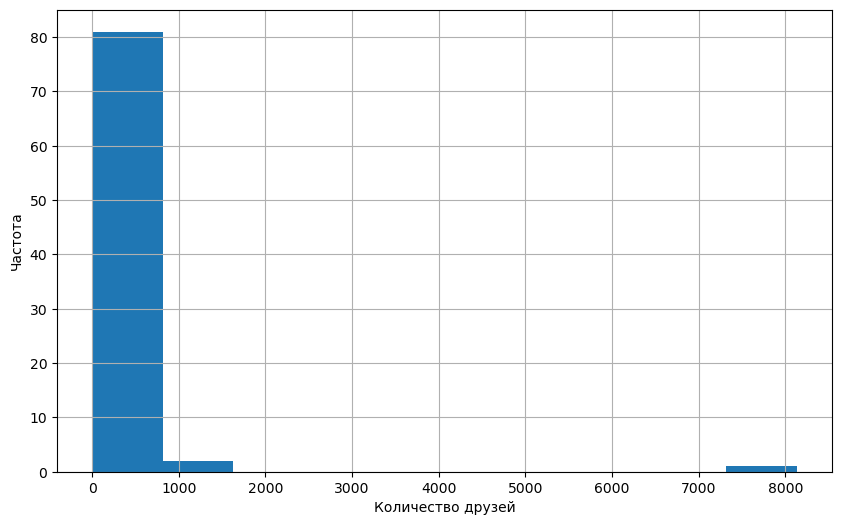

In [10]:
friends['friends_count'].hist()
plt.xlabel('Количество друзей')
plt.ylabel('Частота')
plt.show()

Мы видим выброс на отметке в 8000, отсортируем список друзей по убыванию количества друзей и выведем по 10 человек с верхей и нижней части списка

In [11]:
sorted_by_friends_count = friends.sort_values('friends_count', ascending=False)

Выведем 10 человек с наибольшим количеством друзей

In [12]:
sorted_by_friends_count.head(10)

,id,first_name,last_name,friends_count,mutual_count
82,779437157,Единый,Пункт,8132,3
3,14054379,Алексей,Гукай,954,16
25,134128755,Александр,Асташенко,818,2
73,465302644,Никитос,Денисенко,718,19
35,165120925,Сергей,Королёв,652,0
70,433384256,Владислав,Асламов,626,8
37,170129995,Людмила,Мустафина,617,13
24,132251709,Костя,Шиш,597,9
4,14318595,Светлана,Плотникова,592,6
21,104038097,Сергей,Ренкас,562,11


Выведем 10 человек с наименьшим количеством друзей

In [13]:
sorted_by_friends_count.tail(10)

,id,first_name,last_name,friends_count,mutual_count
47,210860203,Валерий,Перетятько,77,6
36,166586115,Владимир,Кукса,75,8
83,784972938,Илья,Полянцев,65,9
71,437550802,Снежана,Снежная,61,3
51,228617275,Николай,Миронов,57,10
10,37600999,Сергей,Щербаков,42,2
67,365804473,Светлана,Елисеева,29,6
58,249815952,Яромир,Усатюк,27,8
69,419765254,Глеб,Афанасьев,15,9
75,484449309,Vadim,Eliseev,2,1


На 1-м месте по числу друзей находится бизнес-аккаунт, построим гистограмму распределения количеств друзей друзей без учета этого аккаунта

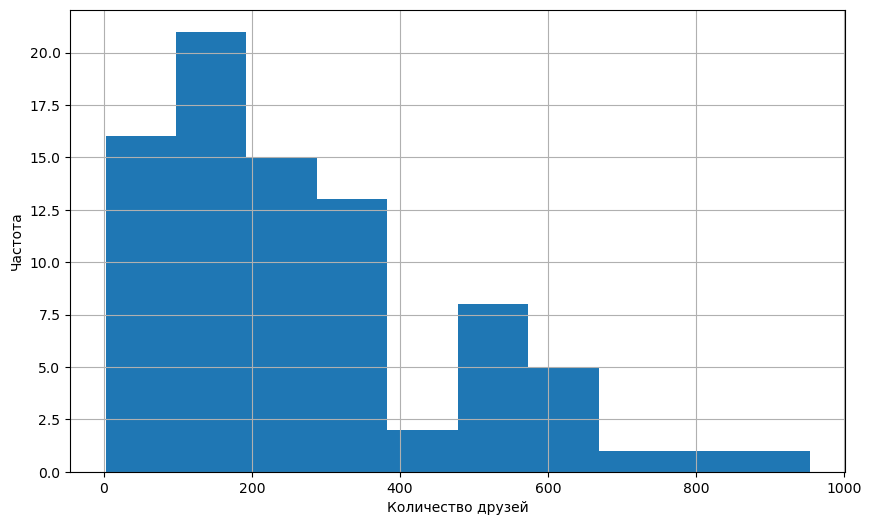

In [14]:
friends[friends['friends_count'] < 8000]['friends_count'].hist()
plt.xlabel('Количество друзей')
plt.ylabel('Частота')
plt.show()

Построим гистограмму распределения количеств общих друзей

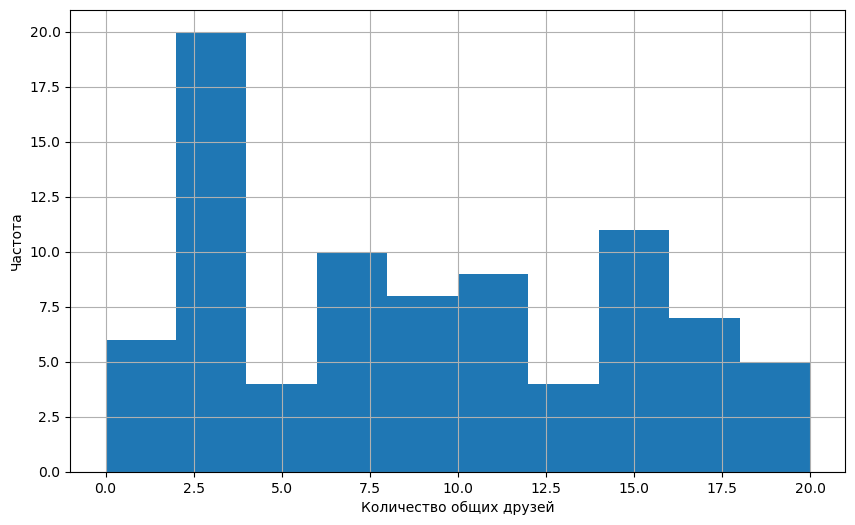

In [15]:
friends['mutual_count'].hist()
plt.xlabel('Количество общих друзей')
plt.ylabel('Частота')
plt.show()

Построим график зависимости числа общих друзей от числа друзей пользователей

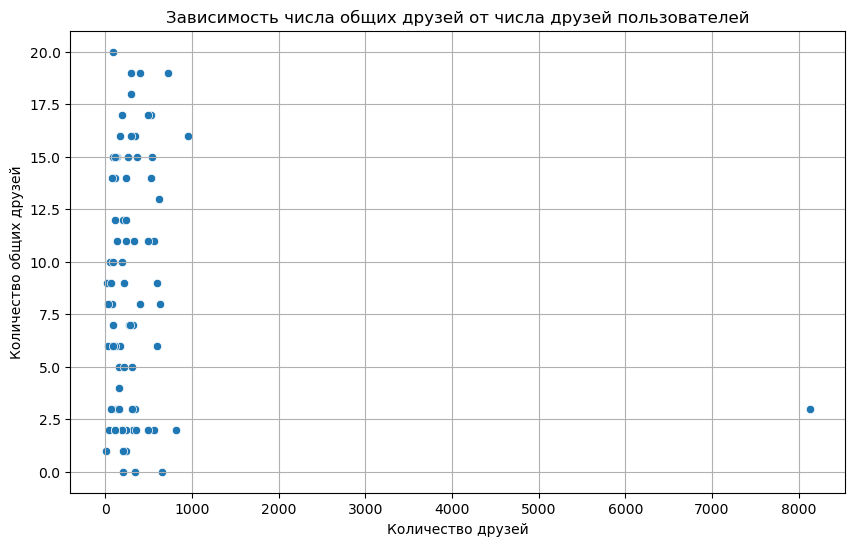

In [16]:
sns.scatterplot(x='friends_count', y='mutual_count', data=friends, edgecolor='w', linewidth=0.5)
plt.title('Зависимость числа общих друзей от числа друзей пользователей')
plt.xlabel('Количество друзей')
plt.ylabel('Количество общих друзей')
plt.grid()
plt.show()

Исключим точку-выброс

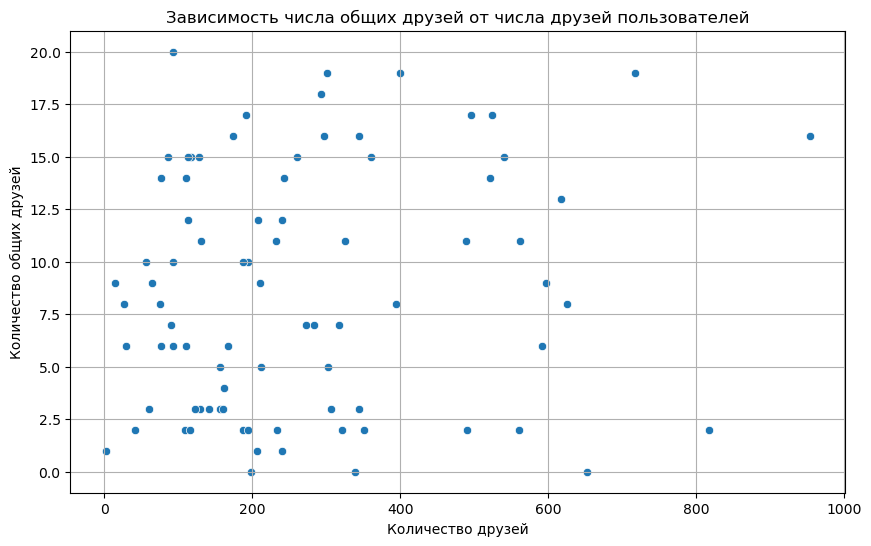

In [17]:
sns.scatterplot(x='friends_count', y='mutual_count', data=friends[friends['friends_count'] < 8000], 
                                                                  edgecolor='w', linewidth=0.5)
plt.title('Зависимость числа общих друзей от числа друзей пользователей')
plt.xlabel('Количество друзей')
plt.ylabel('Количество общих друзей')
plt.grid()
plt.show()

Преобразуем информацию о друзьях в список, что поможет при дальшейшей обработке

In [18]:
friends_records = friends.to_dict(orient='records')

assert len(friends_records) == friends_count
print("OK!")

OK!


## Вычисление локального коэффициента кластеризации

Чтобы узнать количество ребер социального графа, можно воспользоваться [приложением](https://vk.com/app6747909)

Запустив анализ получим следующий результат:

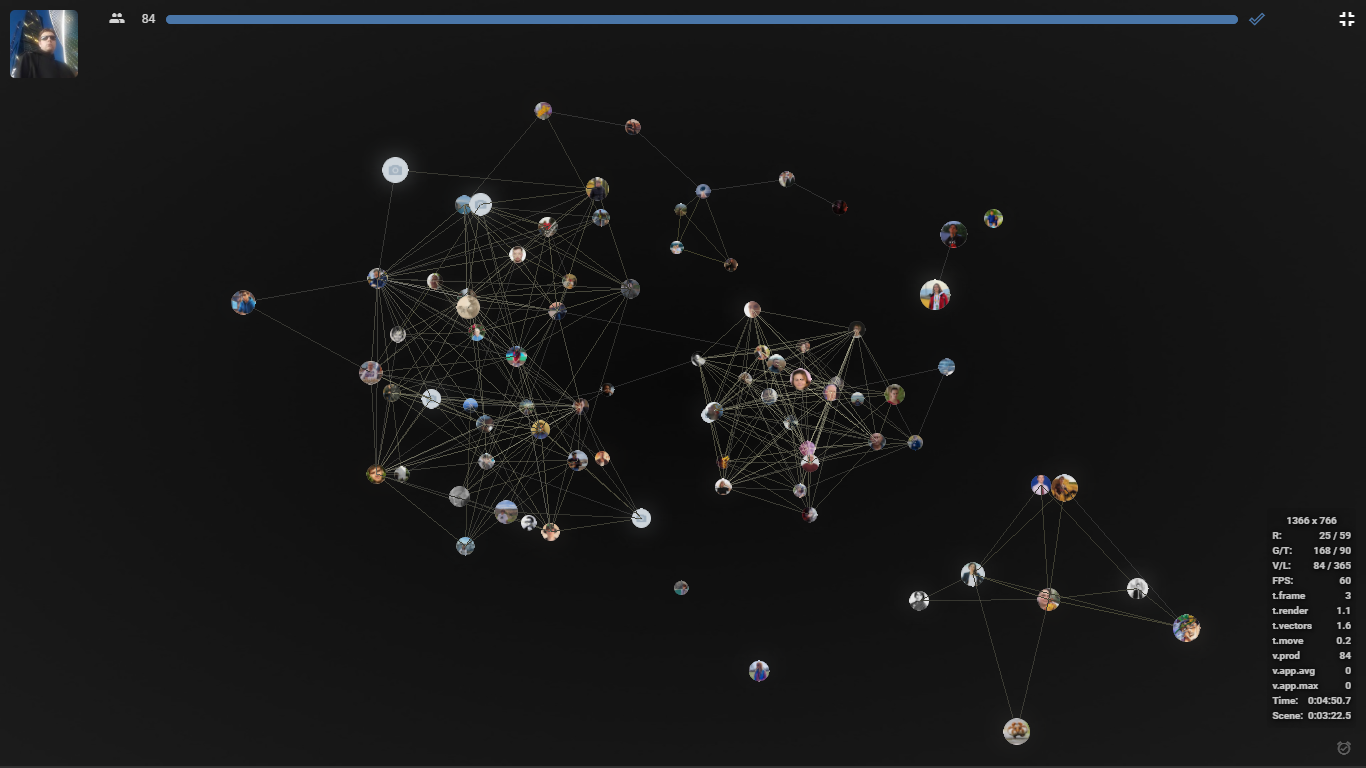

На основе данных из приложения зададим константы

In [19]:
K = 365 # количество ребер
V = 85 # количество вершин (включая анализируемого пользователя)

Вычислим локальный коэффициент кластеризации

In [20]:
M = (V * (V - 1)) / 2 - V
C = K / M
C

0.10473457675753228

Проверим, удовлетворяет ли рассматриваемый кластер сети модели малого мира

Чтобы кластер удовлетворял модели малого мира, необходимо чтобы выполнялось неравенство:
    
$$
\frac{1}{V} \ll C \ll 1
$$

где `V` - число вершин графа, `С` - локальный коэффициент кластеризации

In [21]:
1 / V

0.011764705882352941

$$
\frac{1}{V} = 0.011764705882352941,
C = 0.10473457675753228,
$$

следовательно получим неравенство:

$$
0.011764705882352941 \ll 0.10473457675753228 \ll 1,
$$

которое выполняется с небольшой погрешностью.

Следовательно, мы можем скзать, что рассматриваемый кластер сети <u>***примерно***</u> удовлетворяет модели малого мира

## Вычисление средней длины пути

Вычислим среднюю длину пути в кластере, образованном списком друзей пользователя (сам пользователь также является членом этого кластера)

In [22]:
l = calculate_mean_path_length(friends=friends_records)
l

1.899439775910364

Проверим, на сколько полученное значение L отличается от средней длины пути в модели случайного графа

Средняя длина пути в графе со случайными связями вычисляется следующим образом:

$$
L = \frac{\log_{10}(V)}{\log_{10}(z)}
$$

где `V` - число вершин графа, `z` - среднее число друзей друзей

Вычислим значение z

In [23]:
z = round(friends['friends_count'].mean())
z

361

Посчитаем среднюю длину пути в графе, если бы он был преимущественно со случайными связями

In [24]:
random_world_l = math.log10(V) / math.log10(z)
random_world_l

0.7544138778090783

Вычислим разницу между значениями

In [25]:
l_difference = l - random_world_l
l_difference

1.1450258981012857

Как видно, средняя длина пути в кластере друзей значительно отличается от средняя длина пути, если бы он содержал случайные связи, что говорит о большей концептуальной осмысленности имеющегося графа

## Вычисление времени информирования членов кластера информационной новостью

Предположим, что скорость диффузии информации в кластере такова, что информация распространяется на расстояние L (среднюю длину пути) за 0.5 дня (12 часов). Необходимо определить, через какое время весь социальный кластер будет информирован новостью, созданной любым членом кластера?

Для решения задачи необходимо найти максимальное расстояние между 2-мя членами кластера - это и будет длина пути, которую необходимо пройти новости, чтобы информировать весь кластер

Далее найдем время информирования, используя вычисленную ранее среднюю длину пути и время, за которое информация пройдет ее

In [26]:
farthest_connection = get_farthest_connection(friends=friends_records)
farthest_connection

2

Теперь найдем время, за которое весь социальный кластер будет информирован новостью, созданной любым членом кластера

In [27]:
speed_per_l = 12

time_to_inform = convert_to_hours_and_minutes(speed_per_l * farthest_connection / l)

In [28]:
print(f"Время информирования всего кластера составит примерно {time_to_inform[0]} ч. {time_to_inform[1]} мин.")

Время информирования всего кластера составит примерно 12 ч. 38 мин.
